In [5]:
# 开始训练0-3的mnist模型
import torch 
import torchvision
from torchvision.datasets import mnist 
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch.utils.data import DataLoader

data_tf = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5],[0.5])
    ]
)
data_path = '/home/.faa/data'
batch_size = 256
# 获取数据集
train_data = mnist.MNIST(data_path,train=True,transform=data_tf,download=True)
test_data = mnist.MNIST(data_path,train=False,transform=data_tf,download=True)
train_index = torch.zeros_like(train_data.targets)
test_index = torch.zeros_like(test_data.targets)
for i in range(4):
    train_index |= train_data.targets == i
    test_index |= test_data.targets == i
train_loader_0to3 = DataLoader(Subset(train_data, torch.nonzero(train_index).reshape(-1)), batch_size=batch_size, shuffle=True)
test_loader_0to3 = DataLoader(Subset(test_data, torch.nonzero(test_index).reshape(-1)), batch_size=batch_size, shuffle=True)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, output_channel, hidden1, hidden2, mlp_hidden):
        super(CNN,self).__init__()
        self.view_input_dim=4*4*hidden2
        self.conv1=nn.Conv2d(1,hidden1,5,1)
        self.conv2=nn.Conv2d(hidden1,hidden2,5,1)
        self.fc1=nn.Linear(self.view_input_dim,mlp_hidden)
        self.fc2=nn.Linear(mlp_hidden,output_channel)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=x.view(-1,self.view_input_dim)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.log_softmax(x,dim=1)   

In [8]:
lr=0.005#学习率
momentum=0.5
torch.cuda.set_device(0)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
model=CNN(4, 20, 50, 500).to(device)
optimizer=optim.SGD(model.parameters(),lr=lr,momentum=momentum, weight_decay=0.01)

In [9]:
len(train_data)

60000

In [10]:
num_epochs=5
losses=[]
acces=[]
step = 0
def loop(model,device,train_loader,test_loader, optimizer):
    global step, losses, acces
    model.train()
    for _,(t_data,t_target) in enumerate(train_loader):
        t_data,t_target=t_data.to(device),t_target.to(device)
        pred=model(t_data)
        loss=F.nll_loss(pred,t_target)
        optimizer.zero_grad()#将上一步的梯度清0
        loss.backward()#重新计算梯度
        optimizer.step()#更新参数
        losses.append(loss.detach())
        step += 1
        if step % 50==0:
            model.eval()
            correct=0
            num = 0
            with torch.no_grad():
                for _,(t_data,t_target) in enumerate(test_loader):
                    t_data,t_target=t_data.to(device),t_target.to(device)
                    pred=model(t_data)
                    pred_class=pred.argmax(dim=1)
                    correct+=pred_class.eq(t_target.view_as(pred_class)).sum().item()
                    num += len(t_target)
            acc=correct/num
            print("step:{},accuracy:{}".format(step, acc))
            acces.append(acc)
            model.train()
    
for epoch in range(num_epochs):
    loop(model,device,train_loader_0to3, test_loader_0to3, optimizer)


step:50,accuracy:0.8458022612460909
step:100,accuracy:0.9155641087322588
step:150,accuracy:0.9379360115467885
step:200,accuracy:0.9538128458022612
step:250,accuracy:0.9643974019725764
step:300,accuracy:0.9716141448159731
step:350,accuracy:0.9747414000481116
step:400,accuracy:0.9761847486167909
step:450,accuracy:0.9781092133750301


In [11]:
torch.save(model.state_dict(), '0-3_cnn.ckpt')
import numpy as np
np.savetxt("losses_0to3", losses)
np.savetxt("acces_0to3", acces)

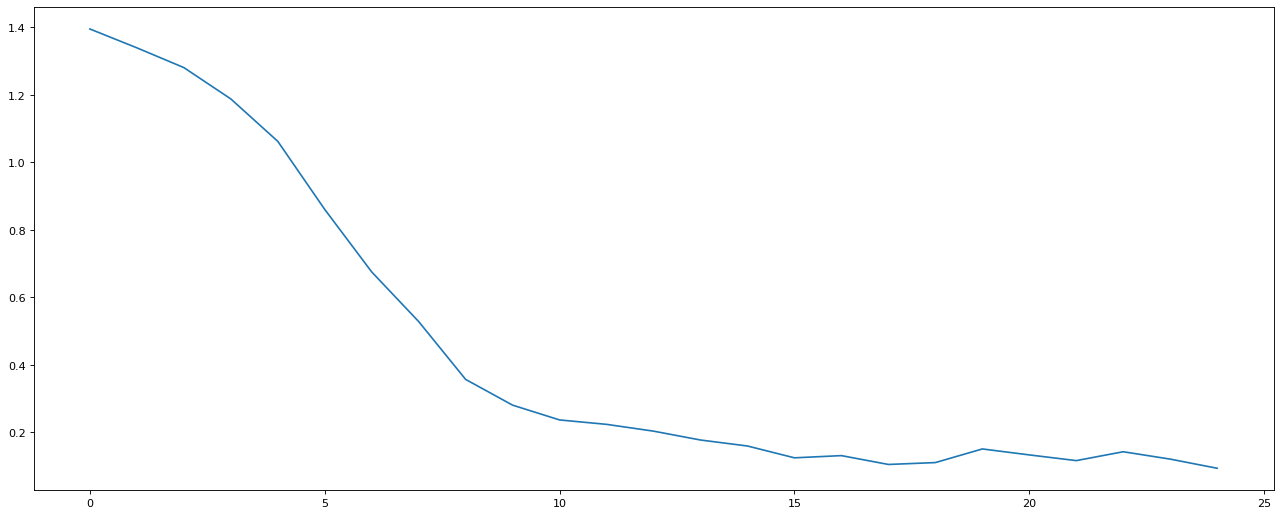

In [5]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# len_l=len(losses)
# x=[i for i in range(len_l)]
# figure=plt.figure(figsize=(20,8),dpi=80)
# plt.plot(x,losses)
# plt.show()